In [55]:
import numpy as np
import os
import os.path

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.stats import pearsonr
from pandas import DataFrame, concat

from anytree import RenderTree
from anytree import PostOrderIter

from pprint import pprint

import gsd.gene_sets
from gsd.distance import calc_pairwise_distances

init_notebook_mode(connected=True)

In [58]:
gene_sets = gsd.gene_sets.load_gene_sets("evaluation_data/reactome/R-HSA-1474290/gene_sets.json")
root = gsd.gene_sets.load_tree("evaluation_data/reactome/R-HSA-1474290/tree.json")
#print(RenderTree( gsd.gene_sets.load_tree("evaluation_data/immune_cells/immune_only/tree.json") ))

categories = [{'subdir':"general",   'label': 'Statistical methods'},
              {'subdir':"go",        'label': 'Gene Ontology methods'},
              {'subdir':"ppi",       'label': 'PPI methods'},
              {'subdir':"nlp",       'label': 'NLP methods'},
              {'subdir':"tree_path", 'label': 'Tree path lengths'}]

def extract_category_df(evaluation_data_name, category):
    score_df = DataFrame()
    for path, subdirs, files in os.walk(os.path.join("experiment_data", category['subdir'])):
        for name in sorted(files):
            if name == "%s.json" % evaluation_data_name:
                record = gsd.gene_sets.load_gene_sets(os.path.join(path, name))
                score_df[record.name] = record.results
    score_df = score_df.reindex(sorted(score_df.columns), axis=1)
    return category['subdir'], score_df

def extract_score_df(evaluation_data_name, co):
    df_list = {name: df for name, df in [extract_category_df(evaluation_data_name, category) for category in categories]}
    return concat(df_list, axis=1, names=["Category", "Metric"])

def create_heatmap(df: DataFrame, method='pearson', min_periods=1): 
    cor = df.corr(method, min_periods).dropna(axis=1, how='all').dropna()

    colorscale = [[0, '#66475e'], [1, '#ecbfe0']]
    font_colors = ['#efecee', '#3c3636']
    fig = ff.create_annotated_heatmap(cor.round(decimals=3).values,
                                      x=[metric for cat, metric in cor.columns],
                                      y=[metric for cat, metric in cor.columns])
    fig.layout.margin.l = 400
    fig.layout.margin.t = 200
    return fig

AnyNode(name='Collagen formation')
├── AnyNode(name='Assembly of collagen fibrils and other multimeric structures')
│   ├── AnyNode(name='Anchoring fibril formation')
│   │   ├── AnyNode(name='Cleavage of collagen VII NC2 region by BMP1')
│   │   ├── AnyNode(name='Collagen type VII binds laminin-322 and collagen IV')
│   │   ├── AnyNode(name='Collagen type VII dimerization')
│   │   └── AnyNode(name='Formation of anchoring fibrils')
│   ├── AnyNode(name='Collagen IX is cross-linked to the surface of collagen type II fibrils')
│   ├── AnyNode(name='Collagen XI cross-links with collagen II')
│   ├── AnyNode(name='Crosslinking of collagen fibrils')
│   │   ├── AnyNode(name='Collagen type IV sulfilimine cross-linking by peroxidasin')
│   │   ├── AnyNode(name='Formation of allysine by LOX')
│   │   ├── AnyNode(name='Formation of dehydro-hydroxylysino-norleucine cross-links')
│   │   ├── AnyNode(name='Formation of dehydro-lysinonorleucine cross-links')
│   │   ├── AnyNode(name='Formation of 

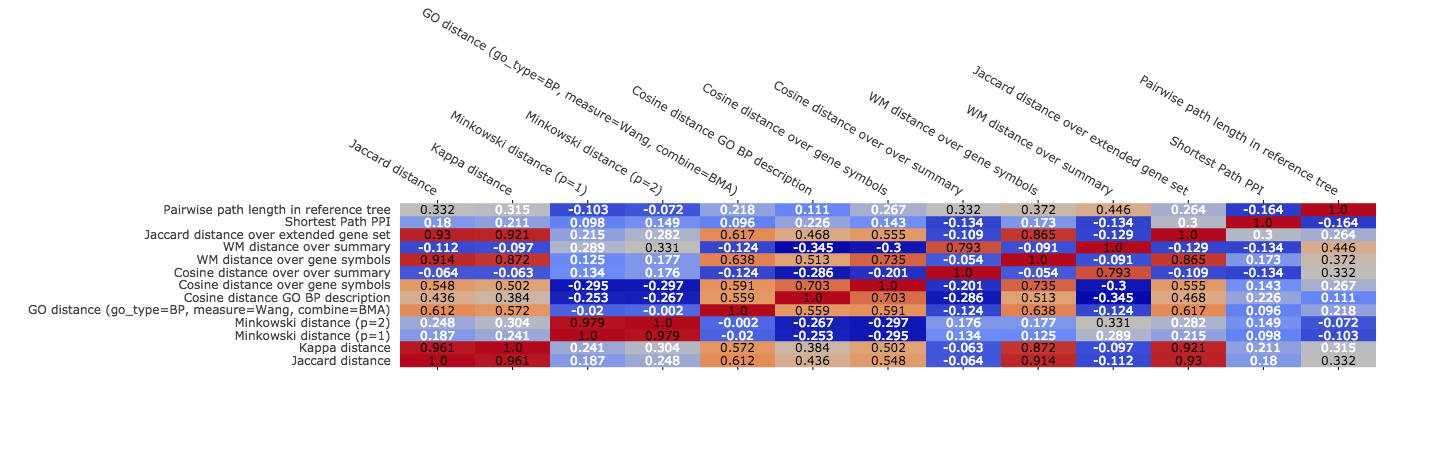

Spearman correlations:


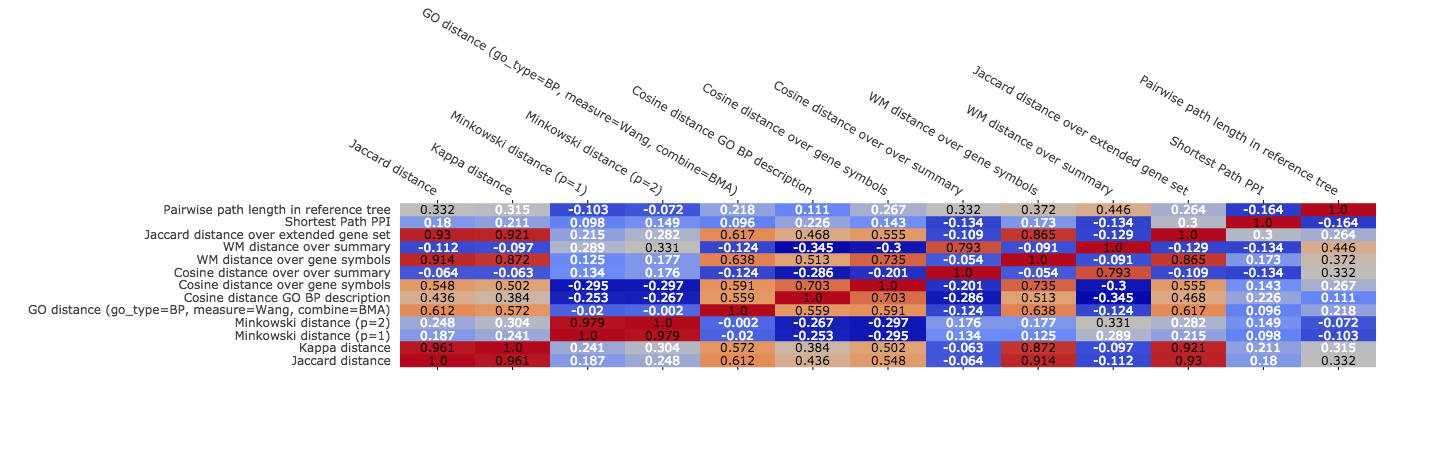

In [66]:
print(RenderTree(gsd.gene_sets.load_tree("evaluation_data/reactome/R-HSA-1474290/tree.json")))
print("Pearson correlations:")
iplot(create_heatmap(extract_score_df("R-HSA-1474290", "pearson")))
print("Spearman correlations:")
iplot(create_heatmap(extract_score_df("R-HSA-1474290", "spearman")))

AnyNode(name='Glycogen metabolism')
├── AnyNode(name='Glycogen breakdown (glycogenolysis)')
│   ├── AnyNode(name='((1,6)-alpha-glucosyl)poly((1,4)-alpha-glucosyl)glycogenin => poly{(1,4)-alpha-glucosyl} glycogenin + alpha-D-glucose')
│   ├── AnyNode(name='GAA hydrolyzes lysosomal glycogen')
│   ├── AnyNode(name='PGM:Mg2+ isomerise G1P to G6P')
│   ├── AnyNode(name='PGYB b dimer:AMP complex <=> PGYB dimer, b form + 2 AMP')
│   ├── AnyNode(name='PGYB dimer, b form + 2 AMP <=> PGYB b dimer:AMP complex')
│   ├── AnyNode(name='PGYM b dimer:AMP complex <=> PGYM dimer, b form + 2 AMP')
│   ├── AnyNode(name='PGYM dimer, b form + 2 AMP <=> PGYM b dimer:AMP complex')
│   ├── AnyNode(name='glycogen phosphorylase (PYGB) dimer b + 2 ATP => glycogen phosphorylase (PYGB) dimer a + 2 ADP')
│   ├── AnyNode(name='glycogen phosphorylase (PYGL) dimer b + 2 ATP => glycogen phosphorylase (PYGL) dimer a + 2 ADP')
│   ├── AnyNode(name='glycogen phosphorylase (PYGM) dimer b + 2 ATP => glycogen phosphorylase (P

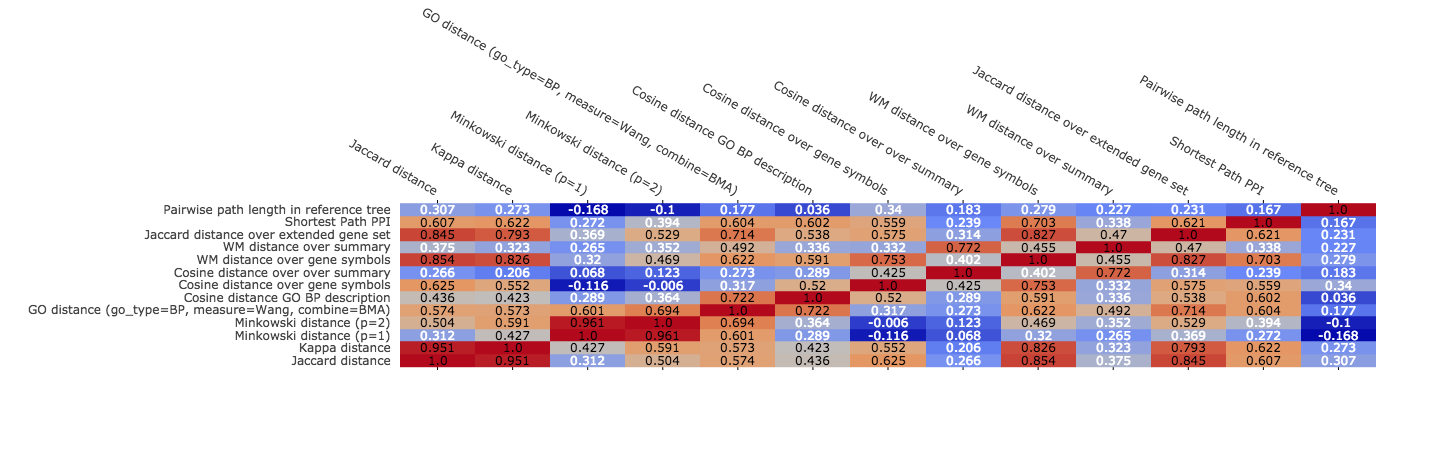

Spearman correlations:


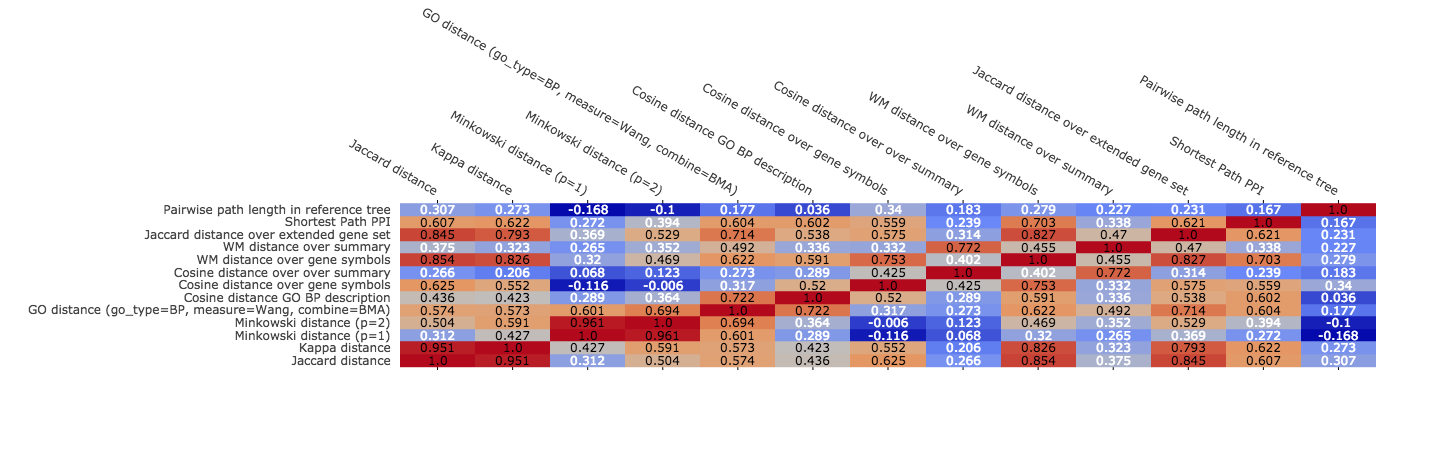

In [68]:
print(RenderTree(gsd.gene_sets.load_tree("evaluation_data/reactome/R-HSA-8982491/tree.json")))
print("Pearson correlations:")
iplot(create_heatmap(extract_score_df("R-HSA-8982491", "pearson")))
print("Spearman correlations:")
iplot(create_heatmap(extract_score_df("R-HSA-8982491", "spearman")))

AnyNode(name='immune cell')
├── AnyNode(name='lymphoid')
│   ├── AnyNode(name='T cell')
│   │   ├── AnyNode(name='T cell CD8+')
│   │   ├── AnyNode(name='T cell CD4+')
│   │   │   ├── AnyNode(name='T cell CD4+ (non-regulatory)')
│   │   │   │   ├── AnyNode(name='T cell CD4+ naive')
│   │   │   │   ├── AnyNode(name='T cell CD4+ memory ')
│   │   │   │   │   ├── AnyNode(name='T cell CD4+ memory resting')
│   │   │   │   │   └── AnyNode(name='T cell CD4+ memory activated')
│   │   │   │   └── AnyNode(name='T cell follicular helper')
│   │   │   └── AnyNode(name='T cell regulatory (Tregs)')
│   │   └── AnyNode(name='T cell gamma delta')
│   ├── AnyNode(name='B cell')
│   │   ├── AnyNode(name='B cell naive')
│   │   ├── AnyNode(name='B cell memory')
│   │   └── AnyNode(name='B cell plasma')
│   └── AnyNode(name='NK cell')
│       ├── AnyNode(name='NK cell resting')
│       └── AnyNode(name='NK cell activated')
└── AnyNode(name='myleoid')
    ├── AnyNode(name='Neutrophil')
    ├── AnyNode(na

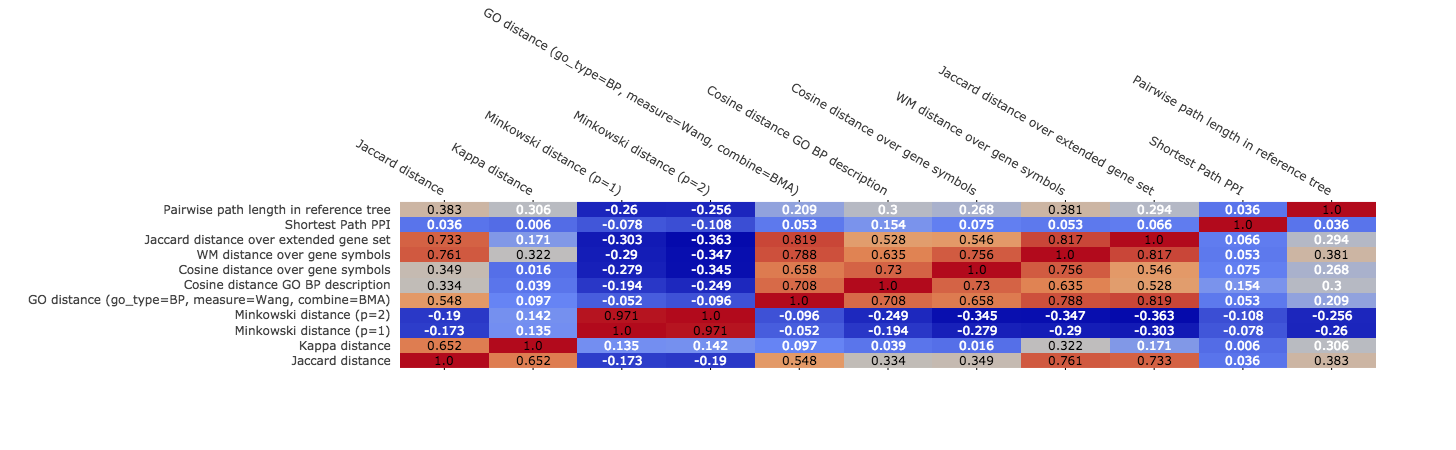

Spearman correlations:


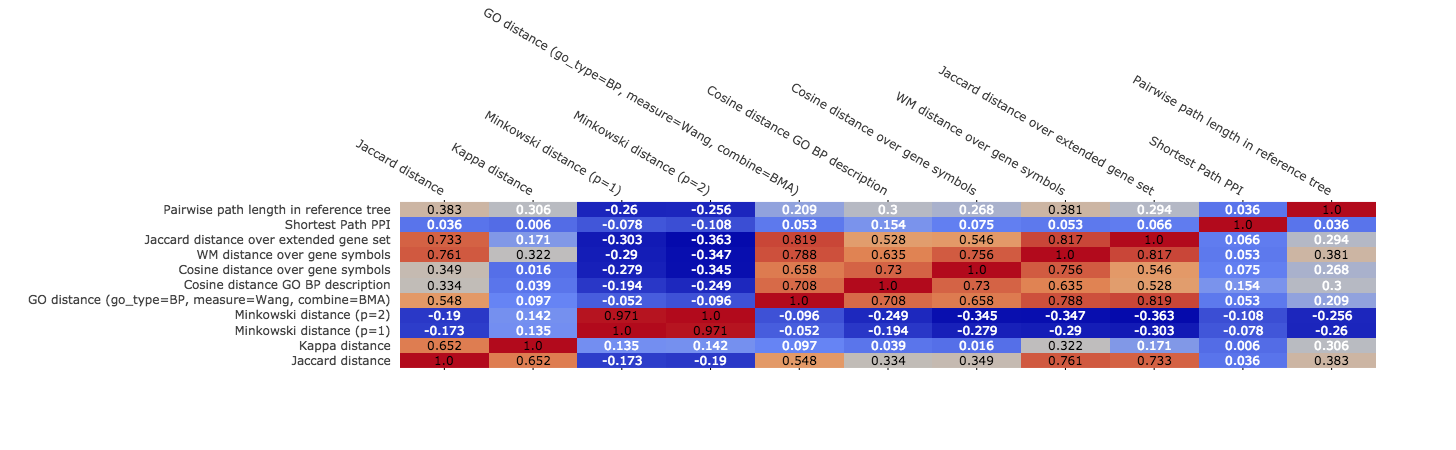

In [69]:
print(RenderTree(gsd.gene_sets.load_tree("evaluation_data/immune_cells/immune_only/tree.json")))
print("Pearson correlations:")
iplot(create_heatmap(extract_score_df("immune_only", "pearson")))
print("Spearman correlations:")
iplot(create_heatmap(extract_score_df("immune_only", "spearman")))